Accuracy: 0.9013994910941476
Precision: 0.8925729442970822
Recall: 0.8426544240400667
F1 Score: 0.866895663374839

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3892
           1       0.89      0.84      0.87      2396

    accuracy                           0.90      6288
   macro avg       0.90      0.89      0.89      6288
weighted avg       0.90      0.90      0.90      6288



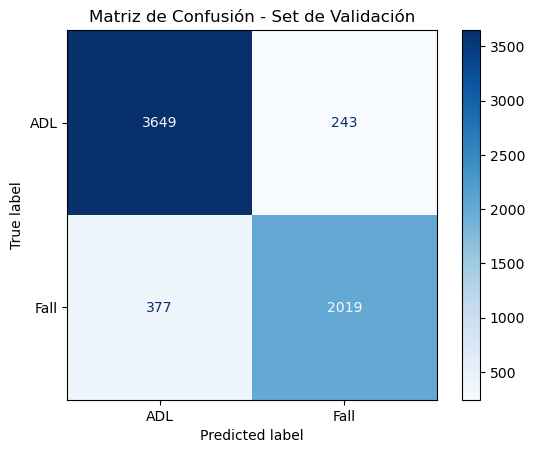

In [1]:
import numpy as np
import glob
import os

from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sympy.physics.quantum.matrixutils import numpy_ndarray

def labels_from_confusion_matrix(cm):
    TN, FP = cm[0]
    FN, TP = cm[1]

    y_true = []
    y_pred = []

    # Clase negativa (0)
    y_true += [0] * (TN + FP)
    y_pred += [0] * TN + [1] * FP

    # Clase positiva (1)
    y_true += [1] * (FN + TP)
    y_pred += [0] * FN + [1] * TP

    return y_true, y_pred


# Ejemplo de matriz 2x2
cm = np.array([[3649, 243],
               [377, 2019]])

y_true, y_pred = labels_from_confusion_matrix(cm)

# Métricas con sklearn
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ADL", "Fall"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Set de Validación")
plt.show()

In [15]:
import os

negatives = 'data/Merged_Dataset_splited_by_subject_for_classification_v2/test/0'
positives = 'data/Merged_Dataset_splited_by_subject_for_classification_v2/test/1'

expected_labels = []

for carpeta, label in ((negatives, 0), (positives, 1)):
    for filepath in glob.glob(os.path.join(carpeta, '*')):
        # basename sin extensión
        name = os.path.splitext(os.path.basename(filepath))[0]
        expected_labels.append({
            'path': name,
            'label': label
        })

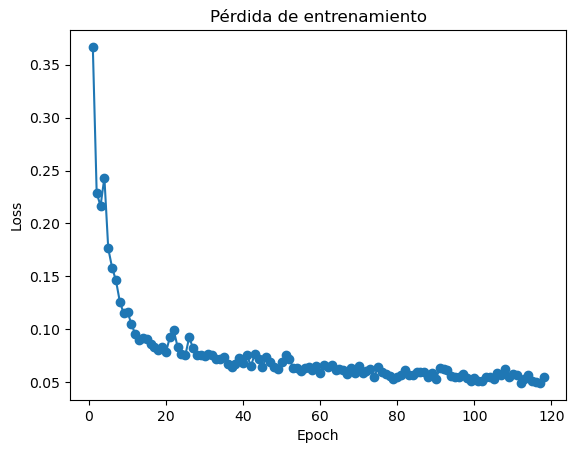

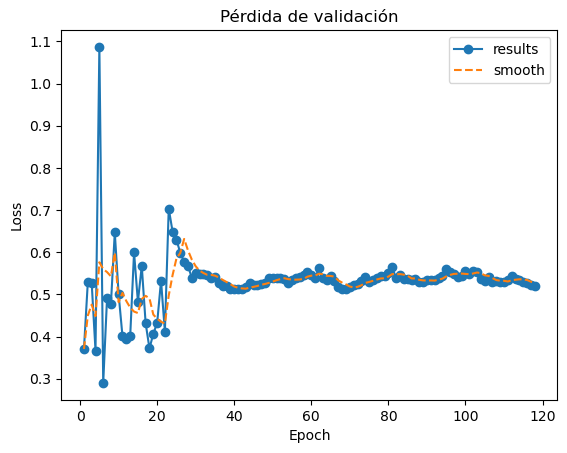

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Carga el CSV (ajusta la ruta al nombre de tu archivo)
df = pd.read_csv('results/runs/classify/train/results.csv')

# Crea una columna suavizada para val/loss usando media móvil
df['val_loss_smooth'] = df['val/loss'].rolling(window=5, min_periods=1).mean()

# Gráfico de train/loss
plt.figure()
plt.plot(df['epoch'], df['train/loss'], marker='o', linestyle='-')
plt.title('Pérdida de entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Gráfico de val/loss con la curva original y la suavizada
plt.figure()
plt.plot(df['epoch'], df['val/loss'], marker='o', linestyle='-', label='results')
plt.plot(df['epoch'], df['val_loss_smooth'], linestyle='--', label='smooth')
plt.title('Pérdida de validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

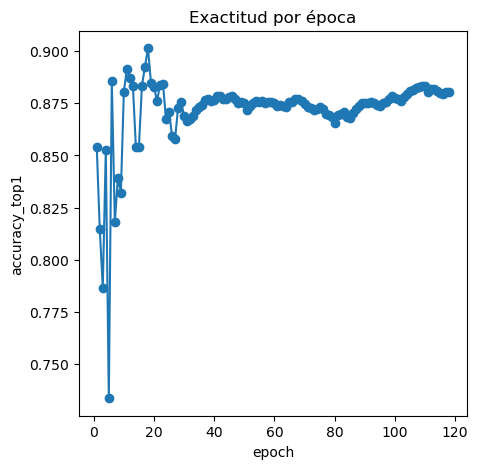

In [3]:
plt.figure(figsize=(5,5))
plt.plot(df['epoch'], df['metrics/accuracy_top1'], marker='o')
plt.title('Exactitud por época')
plt.xlabel('epoch')
plt.ylabel('accuracy_top1')
plt.show()

## Per dataset

In [22]:
import re

def classify_filename(filename):
    # URFD pattern
    urfd_pattern = re.compile(r'^[a-z]+-\d+-cam\d+-.*\.txt$')
    # CAUCAFall pattern
    multicam_pattern = re.compile(r'^\d+_\d+_\d+_\d+\.txt$')
    # MultiCam pattern
    caucafall_pattern = re.compile(r'^[a-z]+[0-9]+_\d+\.txt$')

    if urfd_pattern.match(filename):
        return 1
    elif multicam_pattern.match(filename):
        return 2
    elif caucafall_pattern.match(filename):
        return 3
    else:
        return -1

In [28]:
def calcular_metricas(y_true, y_pred, name):

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=3)
    cm = confusion_matrix(y_true, y_pred)

    # 5. Imprimir resultados
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}\n")

    print("Classification Report:")
    print(report)

    print("Confusion Matrix:")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ADL", "Fall"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusión - Set de Prueba - {name}")
    plt.show()

In [38]:
def get_metrics_from_predictions(predictions, name):
    true_dict = {d["path"]: d["label"] for d in expected_labels}
    pred_dict = {d["path"]: d["label"] for d in predictions}

    common_paths = sorted(set(pred_dict))

    y_true = [int(true_dict[p]) for p in common_paths]
    y_pred = [int(pred_dict[p]) for p in common_paths]

    calcular_metricas(y_true, y_pred, name)

    return true_dict, pred_dict, common_paths

In [33]:
urfd_predict = []
mutlicam_predict = []
caucafall_predict = []
predictions = []

for path in glob.glob('results/test_results/*.txt'):
    with open(path, 'r') as f:
        file_name = os.path.basename(path)
        ds_index = classify_filename(file_name)
        line = f.readline().strip()
        while line == '':
            line = f.readline().strip()
        _, label = line.split()
        to_append = dict(path=os.path.splitext(os.path.basename(path))[0], label=label)

        if ds_index == -1:
            continue
        if ds_index == 1:
            urfd_predict.append(to_append)
        elif ds_index == 2:
            mutlicam_predict.append(to_append)
        elif ds_index == 3:
            caucafall_predict.append(to_append)

        predictions.append(to_append)

Accuracy:  0.8859
Precision: 0.8380
Recall:    0.8644
F1-score:  0.8510

Classification Report:
              precision    recall  f1-score   support

           0      0.916     0.899     0.908      2464
           1      0.838     0.864     0.851      1490

    accuracy                          0.886      3954
   macro avg      0.877     0.882     0.879      3954
weighted avg      0.887     0.886     0.886      3954

Confusion Matrix:
[[2215  249]
 [ 202 1288]]


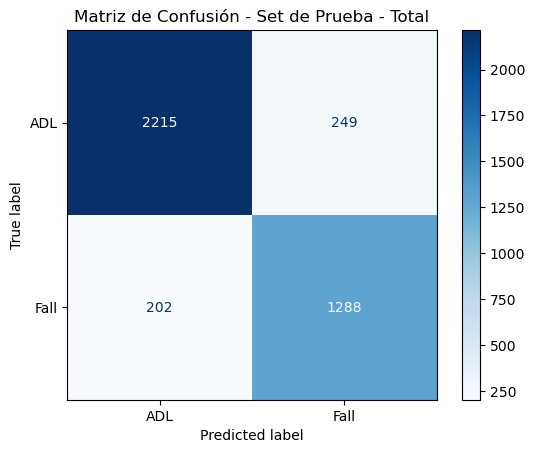

In [39]:
true_dict, pred_dict, common_paths = get_metrics_from_predictions(predictions, name="Total")

Accuracy:  0.9341
Precision: 0.9823
Recall:    0.8810
F1-score:  0.9289

Classification Report:
              precision    recall  f1-score   support

           0      0.897     0.985     0.939       132
           1      0.982     0.881     0.929       126

    accuracy                          0.934       258
   macro avg      0.939     0.933     0.934       258
weighted avg      0.938     0.934     0.934       258

Confusion Matrix:
[[130   2]
 [ 15 111]]


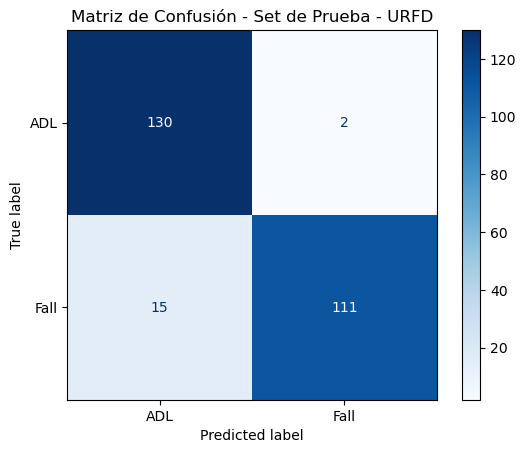

In [35]:
get_metrics_from_predictions(urfd_predict, name="URFD")

Accuracy:  0.7351
Precision: 0.6380
Recall:    0.7410
F1-score:  0.6857

Classification Report:
              precision    recall  f1-score   support

           0      0.815     0.731     0.771       737
           1      0.638     0.741     0.686       471

    accuracy                          0.735      1208
   macro avg      0.727     0.736     0.728      1208
weighted avg      0.746     0.735     0.738      1208

Confusion Matrix:
[[539 198]
 [122 349]]


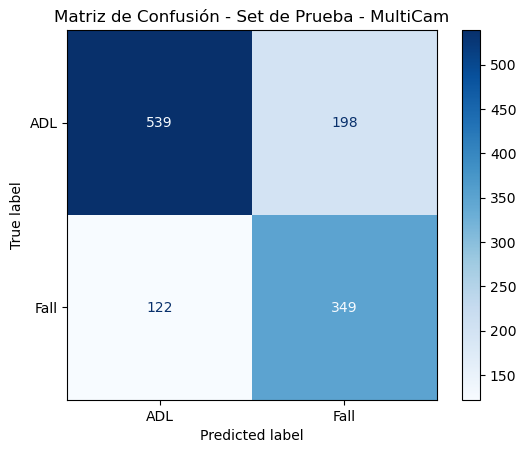

In [36]:
get_metrics_from_predictions(mutlicam_predict, name="MultiCam")

Accuracy:  0.9542
Precision: 0.9441
Recall:    0.9272
F1-score:  0.9356

Classification Report:
              precision    recall  f1-score   support

           0      0.960     0.969     0.964      1595
           1      0.944     0.927     0.936       893

    accuracy                          0.954      2488
   macro avg      0.952     0.948     0.950      2488
weighted avg      0.954     0.954     0.954      2488

Confusion Matrix:
[[1546   49]
 [  65  828]]


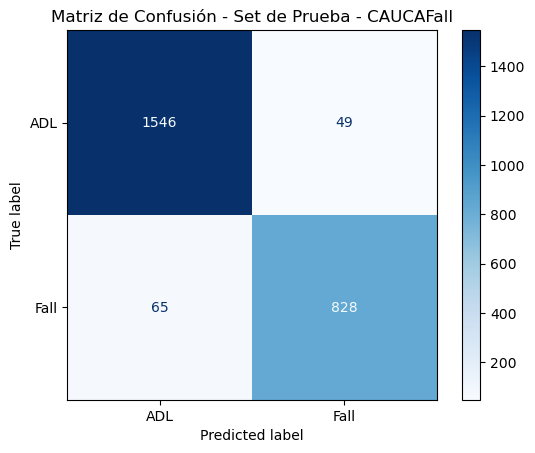

In [37]:
get_metrics_from_predictions(caucafall_predict, name="CAUCAFall")

In [41]:
false_positives = [p for p in common_paths if int(true_dict[p]) == 0 and  int(pred_dict[p]) == 1 ]

false_negatives = [p for p in common_paths if int(true_dict[p]) == 1 and int(pred_dict[p]) == 0]

In [62]:
import random
import matplotlib.pyplot as plt
from PIL import Image

base_path = 'data/Merged_Dataset_splited_by_subject_for_classification_v2/test'

def load_image_with_extensions(base_folder, filename_no_ext):
    path_png = os.path.join(base_folder, filename_no_ext + '.png')
    if os.path.exists(path_png):
        return Image.open(path_png)
    path_jpg = os.path.join(base_folder, filename_no_ext + '.jpg')
    if os.path.exists(path_jpg):
        return Image.open(path_jpg)
    raise FileNotFoundError(f"No se encontró {filename_no_ext} con extensión .png o .jpg")

def plot_images(image_names, title, base_folder, n_images=20):
    random.shuffle(image_names)
    n_images = min(len(image_names), n_images)
    cols = 5
    rows = (n_images + cols - 1) // cols
    plt.figure(figsize=(15, 3*rows))
    for i in range(n_images):
        img = load_image_with_extensions(base_folder, image_names[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
        # Mostrar nombre encima de la imagen
        plt.text(0, 5,  # posición x=0, y=5 pix cerca del borde superior
                 image_names[i].split(os.sep)[-1],  # solo nombre archivo sin carpeta
                 color='white', fontsize=8, backgroundcolor='black', alpha=0.7)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

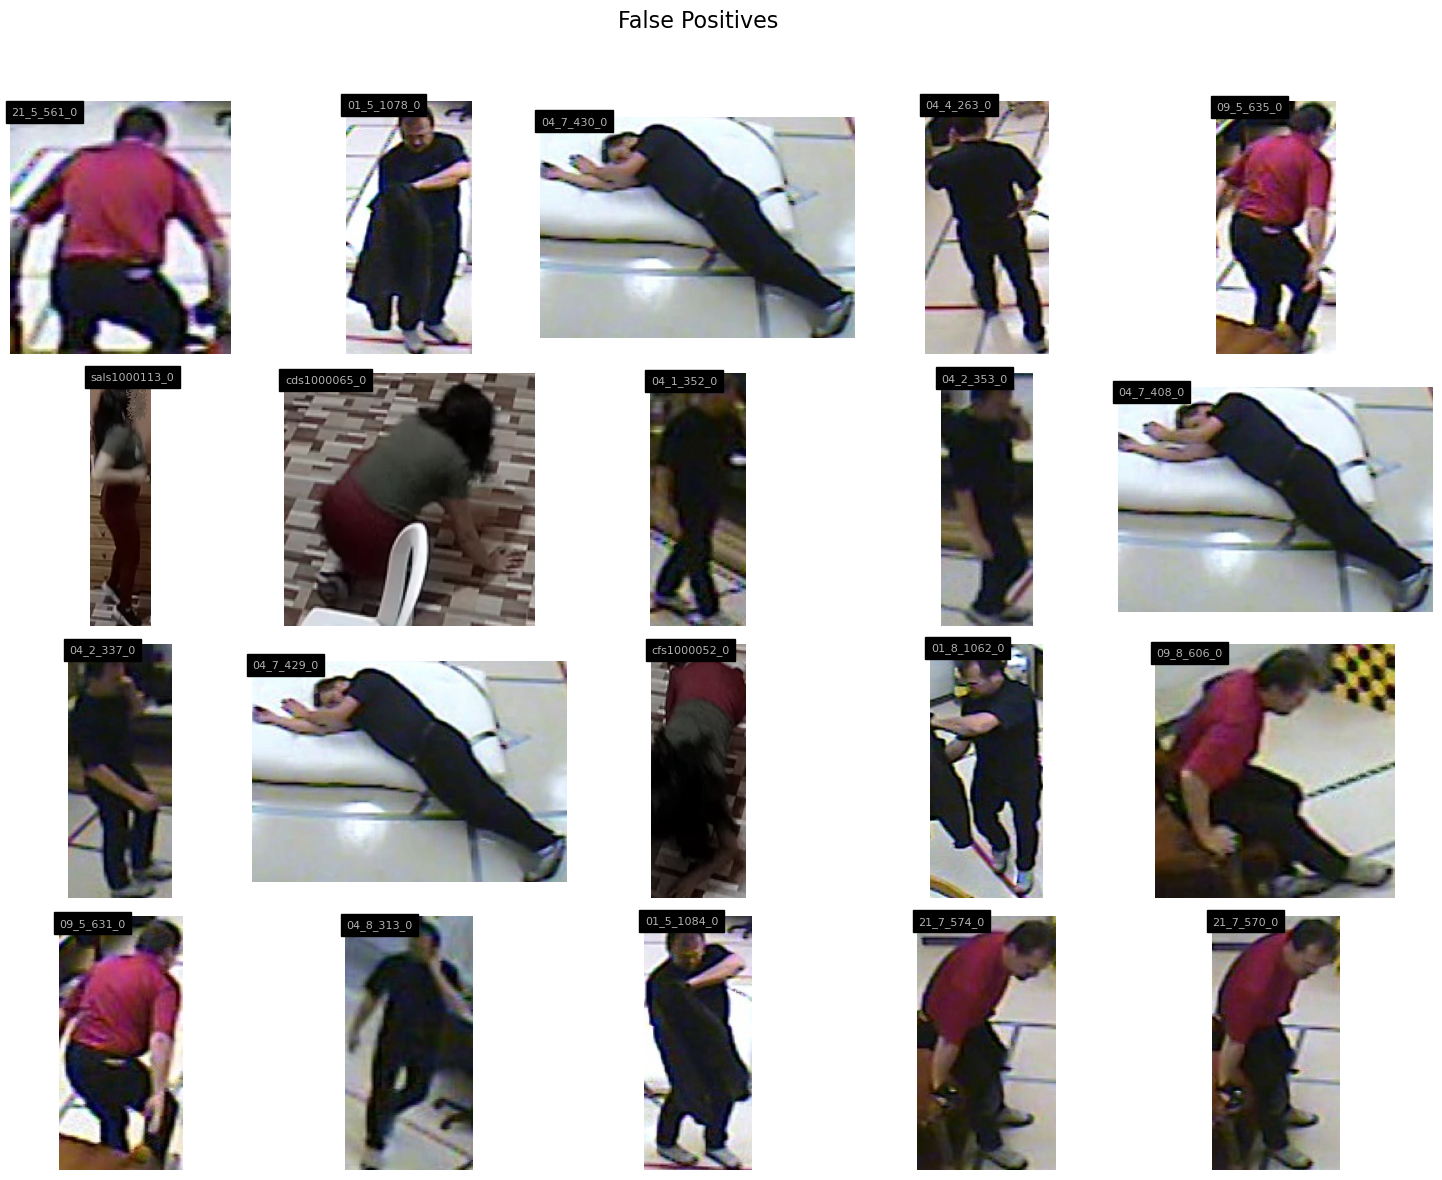

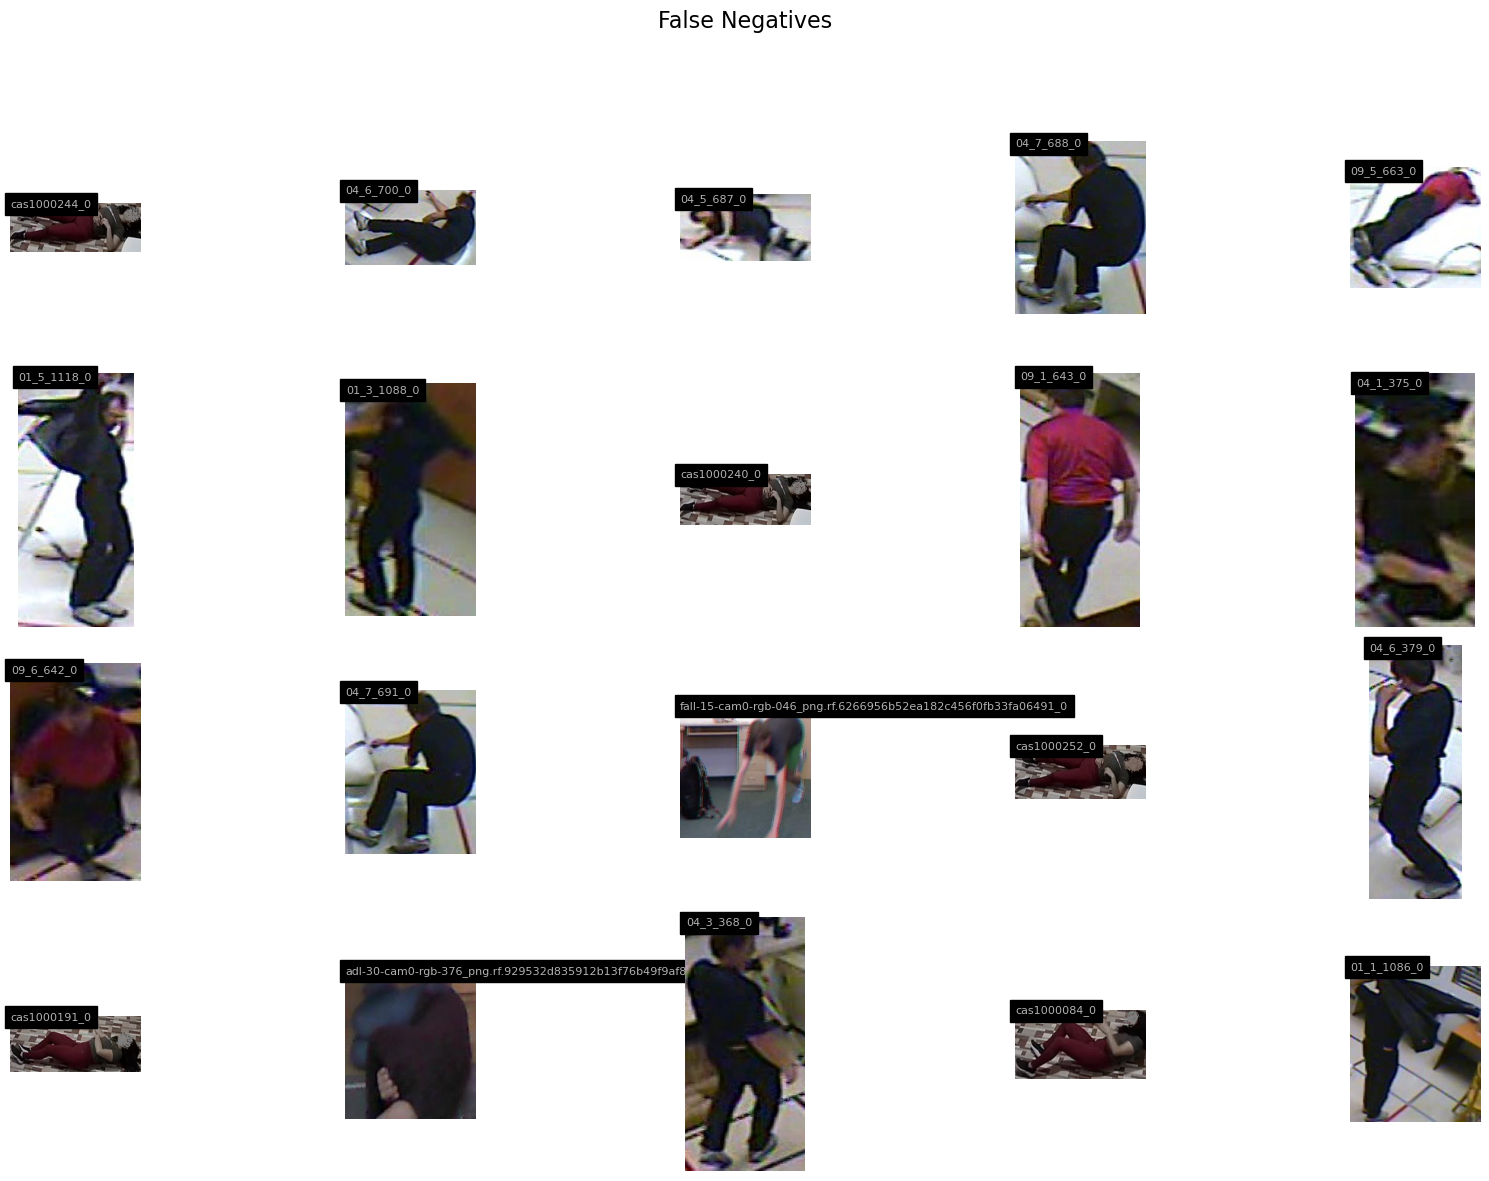

In [63]:
false_positives_paths = [os.path.join('0', f) for f in false_positives]
false_negatives_paths = [os.path.join('1', f) for f in false_negatives]

plot_images(false_positives_paths, 'False Positives', base_path, n_images=20)
plot_images(false_negatives_paths, 'False Negatives', base_path, n_images=20)